## 3 - Applying ViT (pyTorch)
## Feature Extraction

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from transformers import ViTImageProcessor, ViTModel

2025-05-14 01:32:42.473745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747166562.491702   34636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747166562.496786   34636 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747166562.511736   34636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747166562.511791   34636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747166562.511792   34636 computation_placer.cc:177] computation placer alr

In [ ]:
# Load the pre-trained Vision Transformer image processor and model
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model.eval()  # Set the model to evaluation mode


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
def extract_vit_features(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = vit_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Extract the [CLS] token
    return cls_embedding.squeeze().numpy()

In [ ]:
def load_dataset_and_extract_features(root_folder):
    features = []
    labels = []

    for label in os.listdir(root_folder):
        class_dir = os.path.join(root_folder, label)
        if not os.path.isdir(class_dir):
            continue

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            try:
                feat = extract_vit_features(img_path)
                features.append(feat)
                labels.append(label)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    return np.array(features), np.array(labels)


In [ ]:
train_features, train_labels = load_dataset_and_extract_features('dataset/train')
test_features, test_labels = load_dataset_and_extract_features('dataset/test')


In [ ]:
print(train_features[0].shape)
print(train_labels[0])
print(train_labels[5000])

(768,)
malignant
benign


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)

In [ ]:
print(train_labels_encoded[0])
print(train_labels_encoded[5000])

1
0


In [ ]:
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels_encoded)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels_encoded)

## ViT Predictions

/home/rnay/my_py_env/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/rnay/my_py_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:06:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Ensemble Accuracy: 0.914

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       500
           1       0.94      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



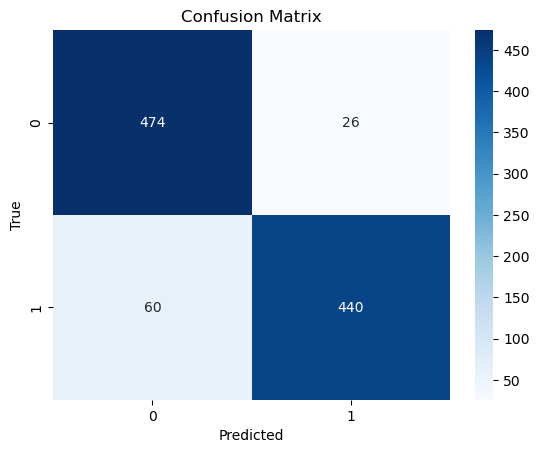

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create classifiers (with scaling where needed)
clf1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=42))
clf4 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
clf5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# VotingClassifier (soft voting uses predicted probabilities)
ensemble_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('rf', clf2),
        ('svm', clf3),
        ('knn', clf4),
        ('xgb', clf5)
    ],
    voting='soft'
)

# Train
ensemble_clf.fit(train_features, train_labels_encoded)

# Predict
y_pred = ensemble_clf.predict(test_features)

# Evaluation
print("\n✅ Ensemble Accuracy:", accuracy_score(test_labels_encoded, y_pred))
print("\n📊 Classification Report:\n", classification_report(test_labels_encoded, y_pred))

# Optional: Confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels_encoded), yticklabels=np.unique(test_labels_encoded))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
